In [1]:
import argparse
import os
import pickle
from collections.abc import Mapping
from functools import partial

import astropy.units as u
import h5py
import haiku as hk
import healpy as hp
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from jax.lib import xla_bridge
from jax_cosmo.redshift import redshift_distribution
from lenstools import ConvergenceMap
from tqdm import tqdm
from unet_model import UResNet

tfp = tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

np.float = float
np.complex = complex

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lenstools.image.convergence import ConvergenceMap
import astropy.units as u
import numpy as np

def power_spectrum(data, map_size, l_edges=np.arange(60.0, 2000.0, 15.0)):
    map = ConvergenceMap(data, angle=map_size*u.deg)
    nu, c = map.powerSpectrum(l_edges)

    return nu, c

def peak_counts(data, map_size, thresholds = None):
    map = ConvergenceMap(data, angle=map_size*u.deg)
    if thresholds is None:
        thresholds = np.arange(map.data.min(),map.data.max(),0.005)
    nu, peaks = map.peakCount(thresholds)

    return nu, peaks

def minkowski_functionals(data, map_size, thresholds=np.arange(-2.0,2.0,0.2)):
    map = ConvergenceMap(data, angle=map_size*u.deg)
    nu,V0,V1,V2 = map.minkowskiFunctionals(thresholds,norm=True)

    return nu,V0,V1,V2

def pdf(data, map_size, thresholds=None):
    map = ConvergenceMap(data, angle=map_size*u.deg)
    if thresholds is None:
        thresholds = np.arange(map.data.min(),map.data.max(),0.005)
    nu,p = map.pdf(thresholds)

    return nu, p

# Forward model

In [3]:
print("######## CONFIG ########")

sigma_e = 0.26
galaxy_density = gal_per_arcmin2 = 10
field_size = map_size = size = 10
field_npix = N = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6
nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area

# Create our fiducial observations
pix_area = (map_size * 60 / N) ** 2  # arcmin2
map_size_rad = map_size / 180 * jnp.pi  # radians

######## CONFIG ########


In [14]:
from jax_cosmo.redshift import redshift_distribution
from jax.tree_util import register_pytree_node_class
import jax.numpy as jnp

@register_pytree_node_class
class smail_nz2(redshift_distribution):
    def pz_fn(self, z):
        a, b, z0 = self.params
        return z**a * jnp.exp(-((z / z0) ** b))*4
    
def Pk_fn(k, cosmo, a_ai=None):
    pz = smail_nz2(3.53, 4.49, 1.03, gals_per_arcmin2=galaxy_density)
    tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    return ps_map * (N / field_size) ** 2

def learned_forward_model():
    Om = numpyro.sample("Om", dist.Uniform(0.1,0.5))
    s8 = numpyro.sample("s8", dist.Uniform(0.4,1.4))
    h = numpyro.sample("h", dist.Uniform(0.64, 0.82))
    Ob = numpyro.sample("Ob", dist.Uniform(0.03,0.06))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
    w0 = numpyro.sample("w0", dist.Uniform(-2.0, -0.333))
    
    z = numpyro.sample(
        "z", dist.MultivariateNormal(loc=jnp.zeros((N, N)), precision_matrix=jnp.eye(N))
    )
    
    cosmo = jc.Planck15(
        Omega_c=Om - Ob,
        Omega_b=Ob,
        h=h,
        n_s=ns,
        sigma8=s8,
        Omega_k=0.0,
        w0=w0,
        wa=0.0,
    )
    
    P = partial(Pk_fn, cosmo=cosmo, a_ai=None)
    power_map = make_power_map(P, N, map_size_rad)
    
    gaussian_map = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real
    x = numpyro.sample(
        "x",
        dist.Independent(
            dist.Normal(gaussian_map.squeeze(), sigma_e / jnp.sqrt(gal_per_arcmin2 * pix_area)), 2
        ),
    )
    
    return x

In [4]:
print("######## OBSERVED DATA ########")
filename = "/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5"
f = h5py.File(filename, "r")
dataset_grid = f["parameters"]["fiducial"]
cosmo_parameters = jnp.array(
    [
        dataset_grid["Om"],
        dataset_grid["s8"],
        dataset_grid["w0"],
        dataset_grid["H0"] / 100,
        dataset_grid["ns"],
        dataset_grid["Ob"],
    ]
).T
truth = list(cosmo_parameters[0])

path = "/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_baryonified512.h5"
m_data = h5py.File(path, "r")
m_data = np.array(m_data["kg"][f"stage3_lensing{4}"]) + np.array(
    m_data["ia"][f"stage3_lensing{4}"]
)

lmax = 3*nside - 1  
power_spectrum_nbody_map = hp.sphtfunc.anafast(m_data, lmax = lmax)
z = np.random.randn(hp.nside2npix(nside)) * np.sqrt(scaling_factor) 
power_spectrum_noise =  hp.sphtfunc.anafast(z, lmax = lmax)
power_spectrum_target = power_spectrum_nbody_map / power_spectrum_noise
alm_hp = hp.map2alm(z, lmax = lmax)
alm = hp.sphtfunc.almxfl(alm_hp, np.sqrt(power_spectrum_target))
gaussian_map = hp.alm2map(alm, nside, lmax = lmax)


proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
m_data_proj = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
projection_gaussian = proj.projmap(gaussian_map, vec2pix_func=partial(hp.vec2pix, nside)) # will change at every run 
m_data_proj_noisy = dist.Independent(
    dist.Normal(
        m_data_proj,
        sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
    ),
    2,
).sample(jax.random.PRNGKey(0), (1,))

projection_gaussian_noisy = dist.Independent(
    dist.Normal(
        projection_gaussian,
        sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
    ),
    2,
).sample(jax.random.PRNGKey(0), (1,))
bruit = dist.Independent(
    dist.Normal(
        projection_gaussian*0,
        sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
    ),
    2,
).sample(jax.random.PRNGKey(0), (1,))

######## OBSERVED DATA ########


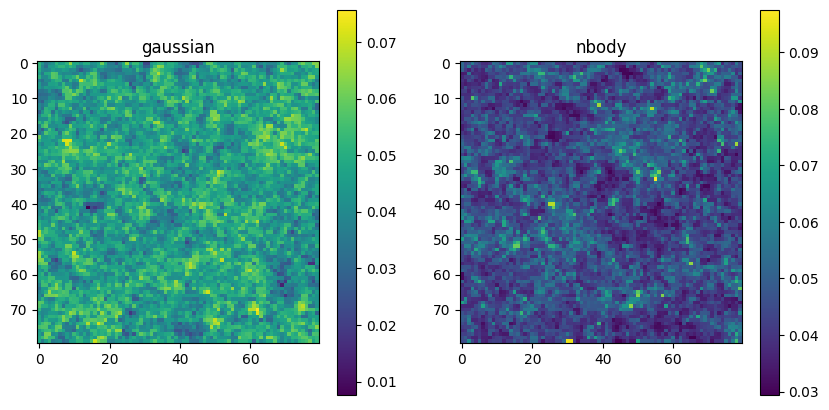

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(projection_gaussian.squeeze())
plt.title("gaussian")
plt.colorbar()
plt.subplot(122)
plt.imshow(m_data_proj.squeeze())
plt.title("nbody")
plt.colorbar()

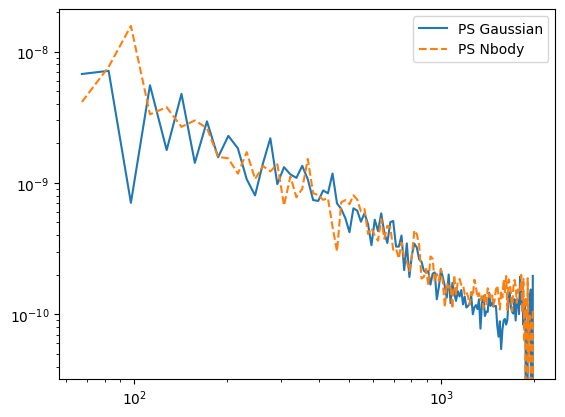

In [6]:
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(projection_gaussian.squeeze(), angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    m_data_proj.squeeze(), angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)


plt.figure()
plt.loglog(l1, Pl1, label="PS Gaussian")
plt.loglog(l2, Pl2, "--", label="PS Nbody")
plt.legend()

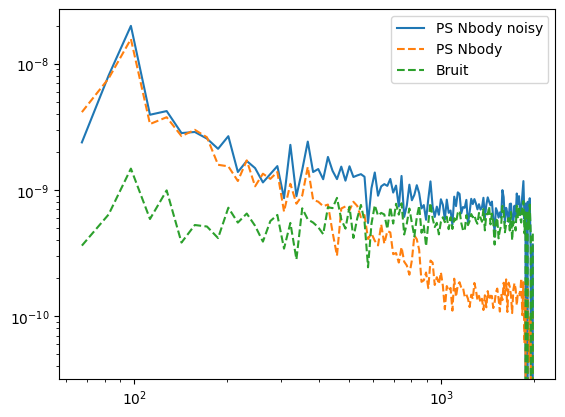

In [7]:
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(m_data_proj_noisy.squeeze(), angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    m_data_proj.squeeze(), angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    bruit.squeeze(), angle=map_size * u.deg
)
l3, Pl3 = kmap_lt_true.powerSpectrum(l_edges_kmap)



plt.figure()
plt.loglog(l1, Pl1, label="PS Nbody noisy")
plt.loglog(l2, Pl2, "--", label="PS Nbody")
plt.loglog(l3, Pl3, "--", label="Bruit")
plt.legend()

## Define VAE

In [8]:
class UResNetEncoder(UResNet):
    """ResNet18."""

    def __init__(
        self,
        bn_config: Mapping[str, float] | None = None,
        use_bn: bool = None,
        pad_crop: bool = False,
        n_output_channels: int = 1,
        name: str | None = None,
    ):
        """Constructs a ResNet model.
        Args:
          bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
            passed on to the :class:`~haiku.BatchNorm` layers.
          resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
            to ``False``.
          use_bn: Whether the network should use batch normalisation. Defaults to
            ``True``.
          n_output_channels: The number of output channels, for example to change in
            the case of a complex denoising. Defaults to 1.
          name: Name of the module.
        """
        super().__init__(
            blocks_per_group=(2, 2),
            bn_config=bn_config,
            bottleneck=False,
            channels_per_group=(4, 8),
            use_projection=(True, True),
            strides=(2, 1),
            use_bn=True,
            pad_crop=pad_crop,
            n_output_channels=n_output_channels,
            name=name,
        )

class ConvDecoder(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        
    def __call__(self, x):
        residual = hk.Conv2D(1, 3, 1)(x)
        residual = jax.nn.leaky_relu(residual)
        residual = hk.Conv2D(1, 3, 1)(residual) 
        residual = jax.nn.leaky_relu(residual)
        residual = hk.Conv2D(1, 3, 1)(residual)
        return (residual + x).squeeze()



# define decoder and encoder

encoder = hk.without_apply_rng(
    hk.transform_with_state(
        lambda x: UResNetEncoder(n_output_channels=2, name="encoder")(
            x.reshape([-1, N, N, 1]), condition=None, is_training=True
        )
    )
)
encoder_eval = hk.without_apply_rng(
    hk.transform_with_state(
        lambda x: UResNetEncoder(n_output_channels=2, name="encoder")(
            x.reshape([-1, N, N, 1]), condition=None, is_training=False
        )
    )
)
params_encoder, state_encoder = encoder.init(
    jax.random.PRNGKey(0), jnp.ones([1, N, N, 1])
)


decoder = hk.without_apply_rng(
    hk.transform_with_state(
        lambda z: ConvDecoder(output_dim=1)(
            z.reshape([-1, N, N, 1])
        )
    )
)
decoder_eval = hk.without_apply_rng(
    hk.transform_with_state(
        lambda z: ConvDecoder(output_dim=1)(
            z.reshape([-1, N, N, 1])
        )
    )
)
params_decoder, state_decoder = decoder.init(
    jax.random.PRNGKey(0), jnp.ones([1, N, N, 1])
)

vae_params = hk.data_structures.merge(params_encoder, params_decoder)


print("######## ELBO LOSS FUNCTION ########")


@jax.jit
def posterior_z(y):
    return tfd.MultivariateNormalDiag(
        loc=y[..., 0].flatten(),
        scale_diag=tfb.Softplus(low=1e-8).forward(y[..., 1].flatten() + 1e-3),
        # scale_diag=jnp.ones([N,N]).flatten()* 1e-8,
    )


@jax.jit
def posterior_x(y):
    return dist.Independent(
        dist.Normal(
            y,
            sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        ),
        2,
    )


@jax.jit
def log_posterior_x(y, x):
    return posterior_x(y).log_prob(x)



2024-06-18 23:54:34.899363: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:799] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1,1,80,80]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1,80,80]{3,2,1,0}, f32[1,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


######## ELBO LOSS FUNCTION ########


In [9]:
import pickle
import os

total_steps = 50_000
lr_rate = 1e-2
batch = 49999
           
PATH_experiment = f"{total_steps}_{lr_rate}_new49"

with open(f"./save_params/{PATH_experiment}/params_nd_vae_batch{batch}.pkl", "rb") as fp:
    vae_params = pickle.load(fp)

with open(f"./save_params/{PATH_experiment}/opt_state_vae_batch{batch}.pkl", "rb") as fp:
    opt_state = pickle.load(fp)

with open(f"./save_params/{PATH_experiment}/state_vae_batch{batch}.pkl", "rb") as fp:
    state = pickle.load(fp)

# Check vae

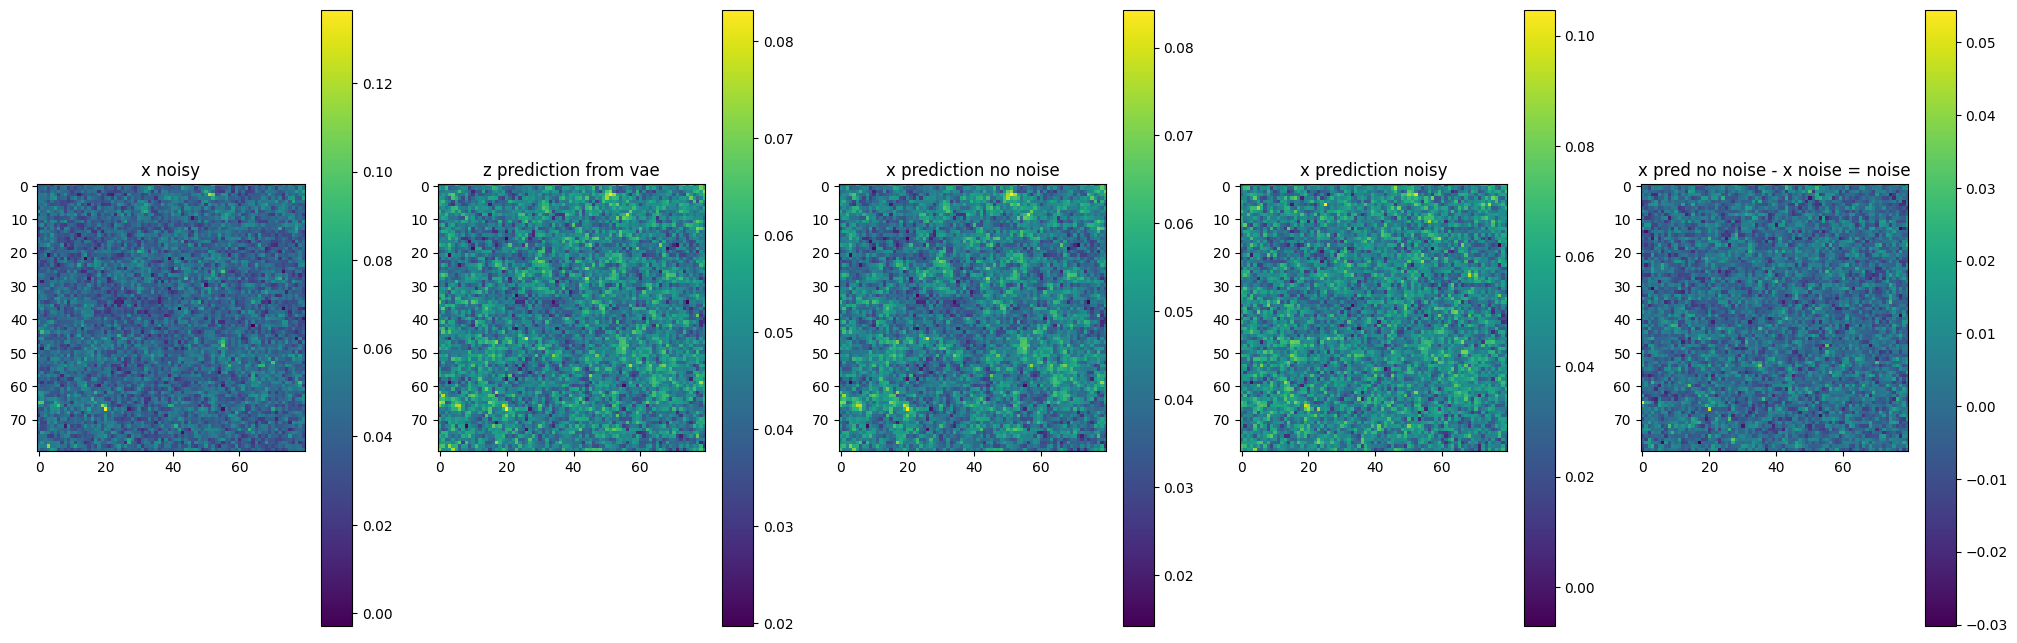

In [72]:
# check learning
out_encoder, _ = encoder_eval.apply(vae_params, state[0], m_data_proj_noisy[0])
sample_encoder = posterior_z(out_encoder.squeeze()).sample(
    seed=jax.random.PRNGKey(0)
)
out_vae, _ = decoder_eval.apply(vae_params, state[1], sample_encoder)
sample_vae = posterior_x(out_vae.squeeze()).sample(jax.random.PRNGKey(10))

plt.figure(figsize=(25, 8))
plt.subplot(152)
plt.imshow(sample_encoder.reshape([N,N]))
plt.title("z prediction from vae")
plt.colorbar()
plt.subplot(153)
plt.imshow(out_vae.squeeze())
plt.title("x prediction no noise")
plt.colorbar()
plt.subplot(151)
plt.imshow(m_data_proj_noisy.squeeze())
plt.title("x noisy")
plt.colorbar()
plt.subplot(154)
plt.imshow(sample_vae.squeeze())
plt.title("x prediction noisy")
plt.colorbar()
plt.subplot(155)
plt.imshow(m_data_proj.squeeze() - out_vae.squeeze())
plt.title("x pred no noise - x noise = noise")
plt.colorbar()

## Statistics

### Re constructed map

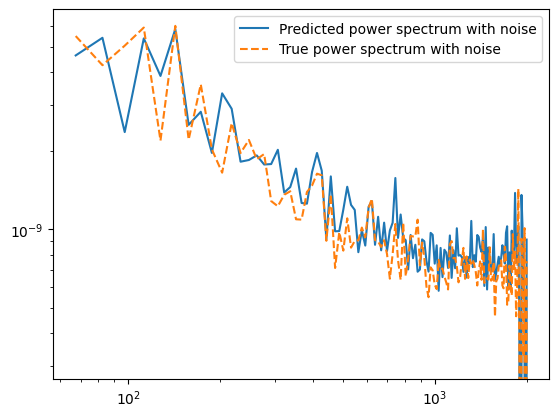

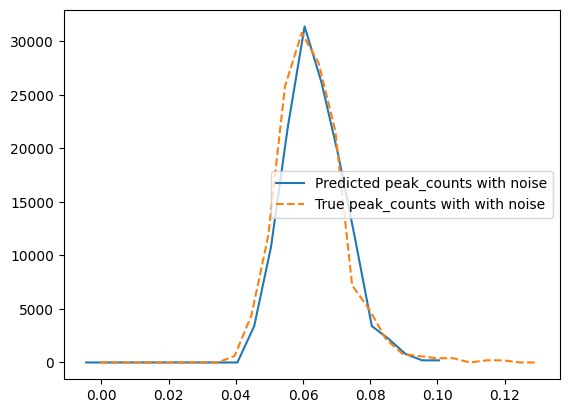

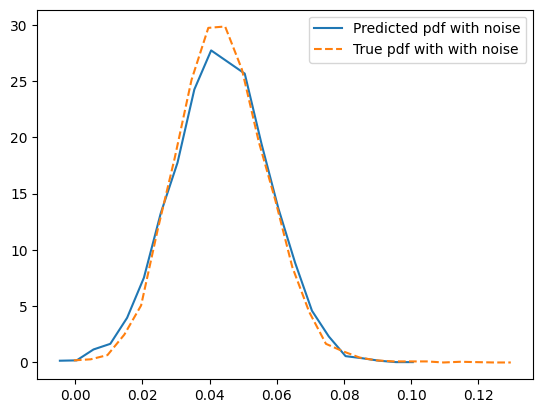

In [73]:
true_map = m_data_proj_noisy.squeeze()
predicted_map = sample_vae.squeeze()
noise = 'with noise'

# power spctrum
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    true_map, angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}")
plt.loglog(l2, Pl2, "--", label=f"True power spectrum {noise}")
plt.legend()

# peak count 
nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
nu, peaks = peak_counts(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}")
plt.plot(nu, peaks, "--", label=f"True peak_counts with {noise}")
plt.legend()

# pdf
nu_vae, peaks_vae = pdf(predicted_map, map_size)
nu, peaks = pdf(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}")
plt.plot(nu, peaks, "--", label=f"True pdf with {noise}")
plt.legend()

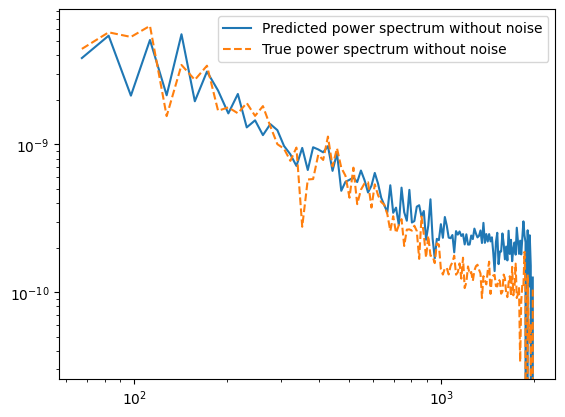

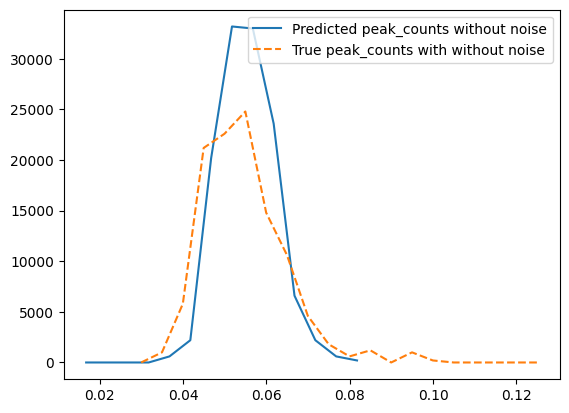

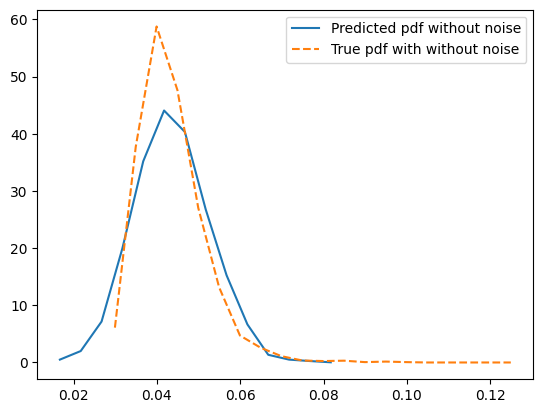

In [74]:
true_map = m_data_proj.squeeze()
predicted_map = out_vae.squeeze()
noise = 'without noise'

# power spctrum
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    true_map, angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}")
plt.loglog(l2, Pl2, "--", label=f"True power spectrum {noise}")
plt.legend()

# peak count 
nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
nu, peaks = peak_counts(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}")
plt.plot(nu, peaks, "--", label=f"True peak_counts with {noise}")
plt.legend()

# pdf
nu_vae, peaks_vae = pdf(predicted_map, map_size)
nu, peaks = pdf(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}")
plt.plot(nu, peaks, "--", label=f"True pdf with {noise}")
plt.legend()

### Latent space

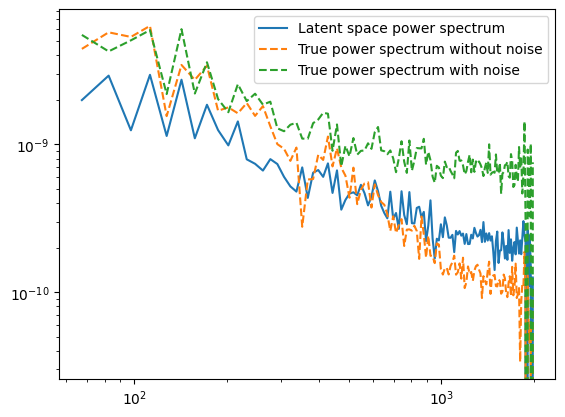

In [75]:
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(sample_encoder.reshape([N,N]).squeeze(), angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    m_data_proj.squeeze(), angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

kmap_lt_true_with_noise = ConvergenceMap(
    m_data_proj_noisy.squeeze(), angle=map_size * u.deg
)
l3, Pl3 = kmap_lt_true_with_noise.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label="Latent space power spectrum")
plt.loglog(l2, Pl2, "--", label="True power spectrum without noise")
plt.loglog(l3, Pl3, "--", label="True power spectrum with noise")
plt.legend()

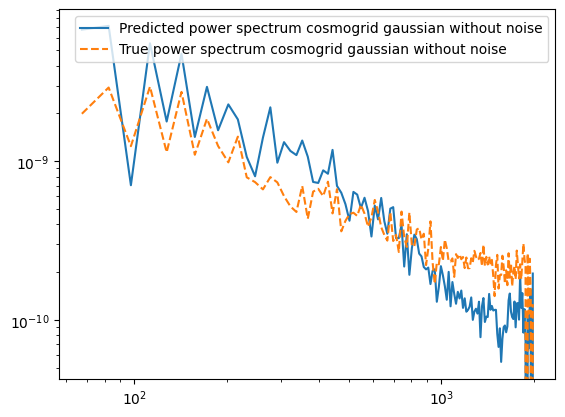

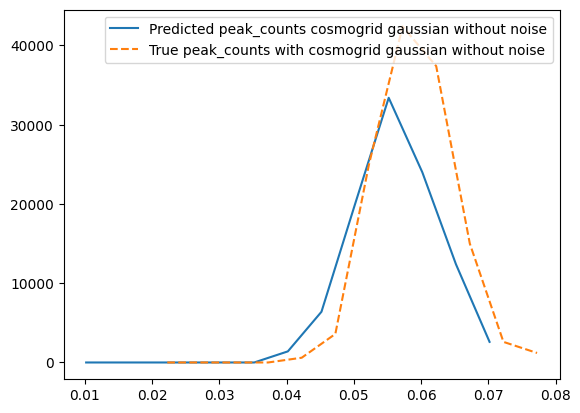

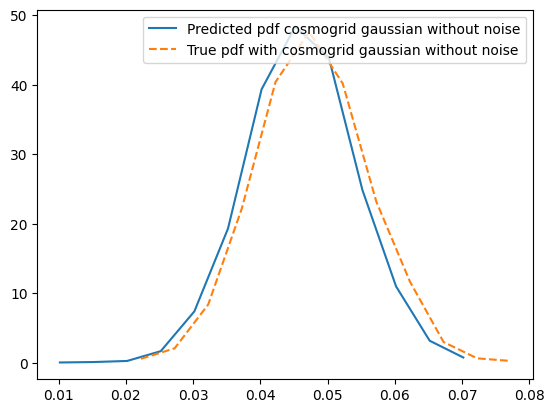

In [76]:
true_map = sample_encoder.reshape([N,N]).squeeze()
predicted_map = projection_gaussian.squeeze()
noise = 'cosmogrid gaussian without noise'

# power spctrum
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    true_map, angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}")
plt.loglog(l2, Pl2, "--", label=f"True power spectrum {noise}")
plt.legend()

# peak count 
nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
nu, peaks = peak_counts(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}")
plt.plot(nu, peaks, "--", label=f"True peak_counts with {noise}")
plt.legend()

# pdf
nu_vae, peaks_vae = pdf(predicted_map, map_size)
nu, peaks = pdf(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}")
plt.plot(nu, peaks, "--", label=f"True pdf with {noise}")
plt.legend()

In [77]:
import numpyro
from numpyro.handlers import condition, reparam, seed, trace
fiducial_model = numpyro.handlers.condition(
    learned_forward_model, 
    {
        "Om": cosmo_parameters[0][0], 
        "s8": cosmo_parameters[0][1], 
        "w0": cosmo_parameters[0][2], 
        "h": cosmo_parameters[0][3], 
        "ns": cosmo_parameters[0][4],
        "Ob": cosmo_parameters[0][5], 
    }
)
model_trace = numpyro.handlers.trace(seed(fiducial_model, jax.random.PRNGKey(124))).get_trace()

gaussian_map_prior = model_trace['x']['fn'].mean

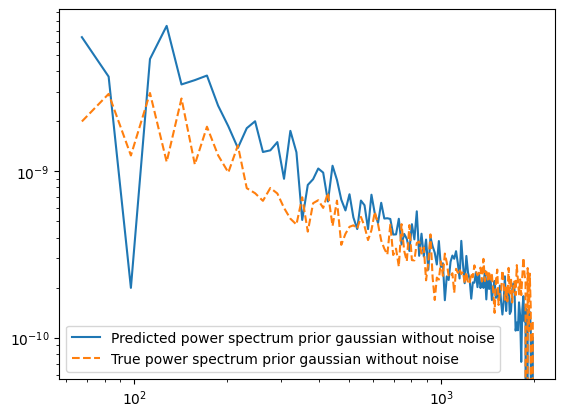

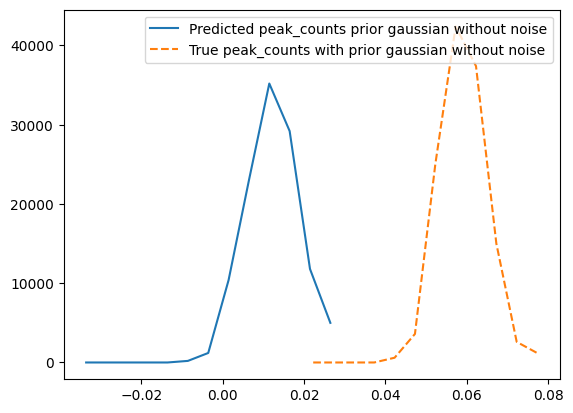

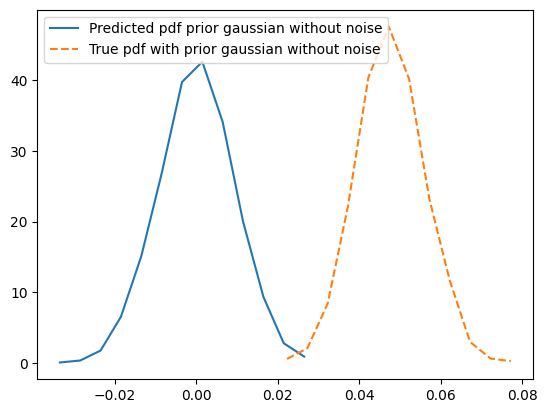

In [78]:
true_map = sample_encoder.reshape([N,N]).squeeze()
predicted_map = gaussian_map_prior.squeeze()
noise = 'prior gaussian without noise'

# power spctrum
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    true_map, angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}")
plt.loglog(l2, Pl2, "--", label=f"True power spectrum {noise}")
plt.legend()

# peak count 
nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
nu, peaks = peak_counts(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}")
plt.plot(nu, peaks, "--", label=f"True peak_counts with {noise}")
plt.legend()

# pdf
nu_vae, peaks_vae = pdf(predicted_map, map_size)
nu, peaks = pdf(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}")
plt.plot(nu, peaks, "--", label=f"True pdf with {noise}")
plt.legend()

## Averaged over several z

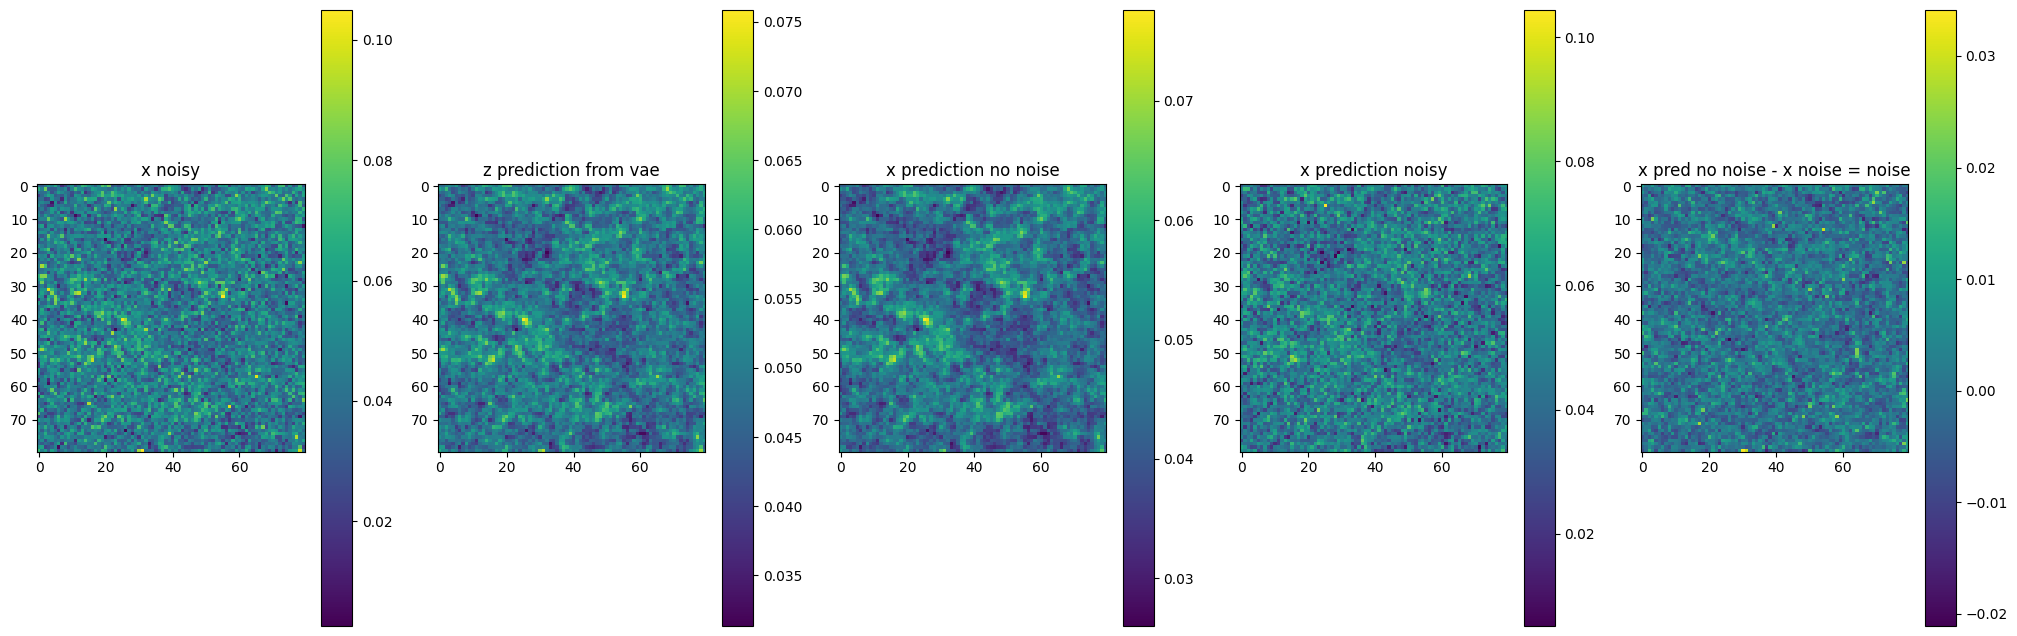

In [23]:
# check learning
out_encoder, _ = encoder_eval.apply(vae_params, state[0], m_data_proj_noisy[0])
sample_encoder = posterior_z(out_encoder.squeeze()).sample(300,seed=jax.random.PRNGKey(0))
mean_sample_encoder = jnp.mean(sample_encoder, axis = 0)
out_vae, _ = decoder_eval.apply(vae_params, state[1], mean_sample_encoder)
sample_vae = posterior_x(out_vae.squeeze()).sample(jax.random.PRNGKey(10))


plt.figure(figsize=(25, 8))
plt.subplot(152)
plt.imshow(mean_sample_encoder.reshape([N,N]))
plt.title("z prediction from vae")
plt.colorbar()
plt.subplot(153)
plt.imshow(out_vae.squeeze())
plt.title("x prediction no noise")
plt.colorbar()
plt.subplot(151)
plt.imshow(m_data_proj_noisy.squeeze())
plt.title("x noisy")
plt.colorbar()
plt.subplot(154)
plt.imshow(sample_vae.squeeze())
plt.title("x prediction noisy")
plt.colorbar()
plt.subplot(155)
plt.imshow(m_data_proj.squeeze() - out_vae.squeeze())
plt.title("x pred no noise - x noise = noise")
plt.colorbar()

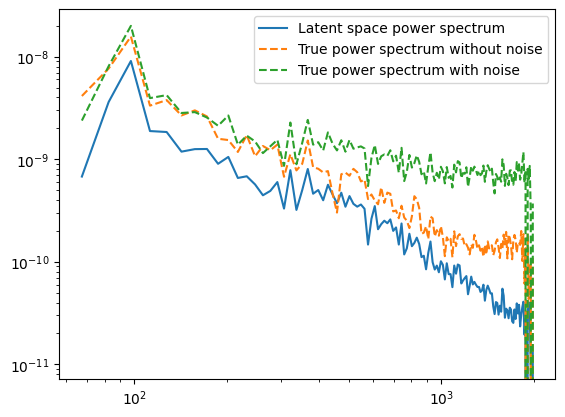

In [24]:
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(mean_sample_encoder.reshape([N,N]).squeeze(), angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    m_data_proj.squeeze(), angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

kmap_lt_true_with_noise = ConvergenceMap(
    m_data_proj_noisy.squeeze(), angle=map_size * u.deg
)
l3, Pl3 = kmap_lt_true_with_noise.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label="Latent space power spectrum")
plt.loglog(l2, Pl2, "--", label="True power spectrum without noise")
plt.loglog(l3, Pl3, "--", label="True power spectrum with noise")
plt.legend()

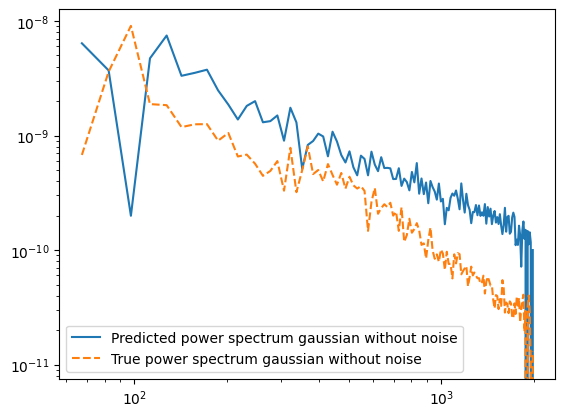

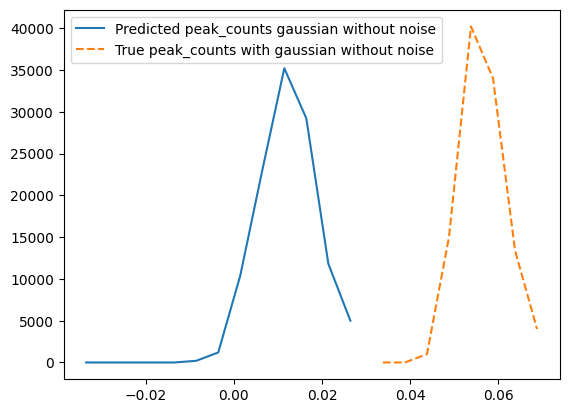

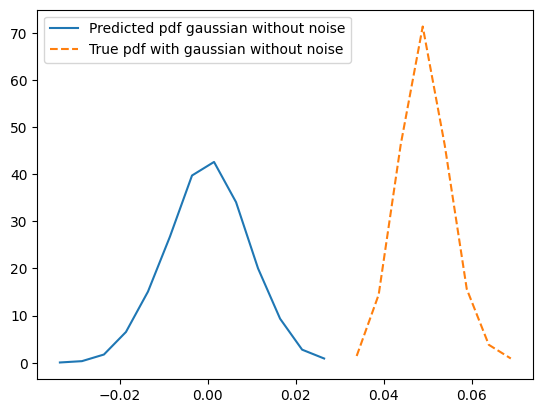

In [25]:
true_map = mean_sample_encoder.reshape([N,N]).squeeze()
predicted_map = gaussian_map_prior.squeeze()
noise = 'gaussian without noise'

# power spctrum
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    true_map, angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}")
plt.loglog(l2, Pl2, "--", label=f"True power spectrum {noise}")
plt.legend()

# peak count 
nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
nu, peaks = peak_counts(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}")
plt.plot(nu, peaks, "--", label=f"True peak_counts with {noise}")
plt.legend()

# pdf
nu_vae, peaks_vae = pdf(predicted_map, map_size)
nu, peaks = pdf(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}")
plt.plot(nu, peaks, "--", label=f"True pdf with {noise}")
plt.legend()

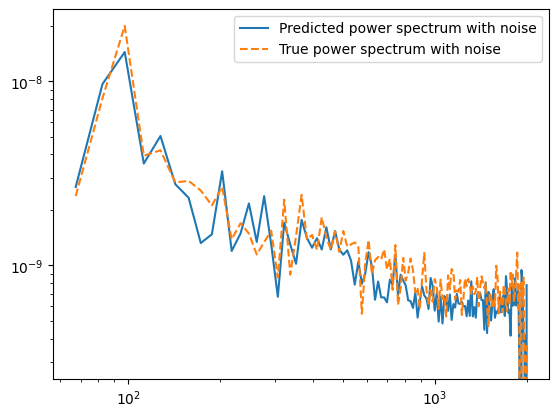

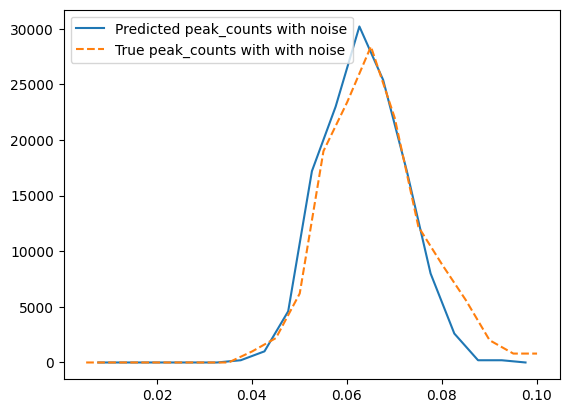

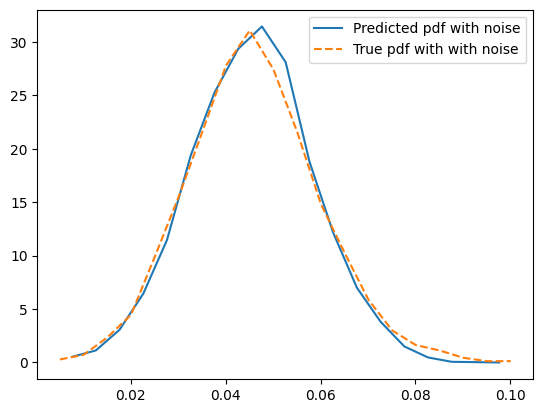

In [26]:
true_map = m_data_proj_noisy.squeeze()
predicted_map = sample_vae.squeeze()
noise = 'with noise'

# power spctrum
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    true_map, angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}")
plt.loglog(l2, Pl2, "--", label=f"True power spectrum {noise}")
plt.legend()

# peak count 
nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
nu, peaks = peak_counts(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}")
plt.plot(nu, peaks, "--", label=f"True peak_counts with {noise}")
plt.legend()

# pdf
nu_vae, peaks_vae = pdf(predicted_map, map_size)
nu, peaks = pdf(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}")
plt.plot(nu, peaks, "--", label=f"True pdf with {noise}")
plt.legend()

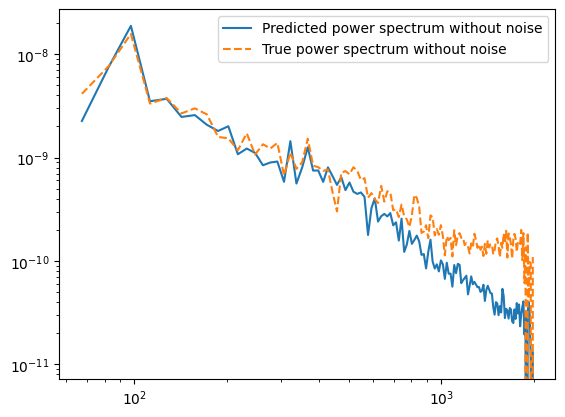

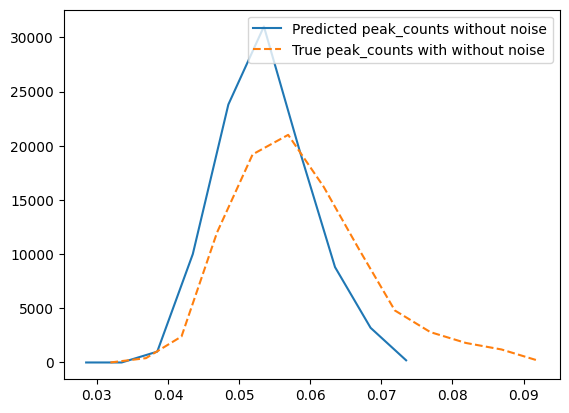

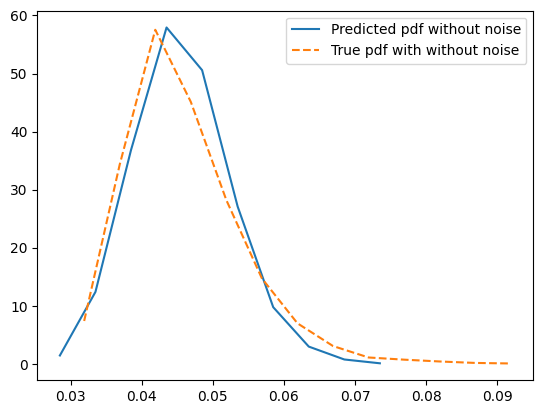

In [27]:
true_map = m_data_proj.squeeze()
predicted_map = out_vae.squeeze()
noise = 'without noise'

# power spctrum
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    true_map, angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.figure()
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}")
plt.loglog(l2, Pl2, "--", label=f"True power spectrum {noise}")
plt.legend()

# peak count 
nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
nu, peaks = peak_counts(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}")
plt.plot(nu, peaks, "--", label=f"True peak_counts with {noise}")
plt.legend()

# pdf
nu_vae, peaks_vae = pdf(predicted_map, map_size)
nu, peaks = pdf(true_map, map_size)

plt.figure()
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}")
plt.plot(nu, peaks, "--", label=f"True pdf with {noise}")
plt.legend()

# Check decoding 

## From cosmogrid gaussian map

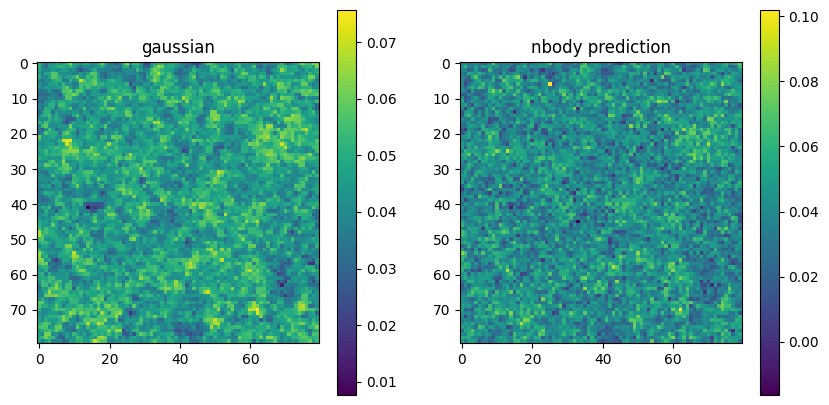

In [49]:
out_vae, _ = decoder_eval.apply(vae_params, state[1], projection_gaussian)
sample_vae = posterior_x(out_vae.squeeze()).sample(jax.random.PRNGKey(10))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(projection_gaussian)
plt.title("gaussian")
plt.colorbar()
plt.subplot(122)
plt.imshow(sample_vae.squeeze())
plt.title("nbody prediction")
plt.colorbar()

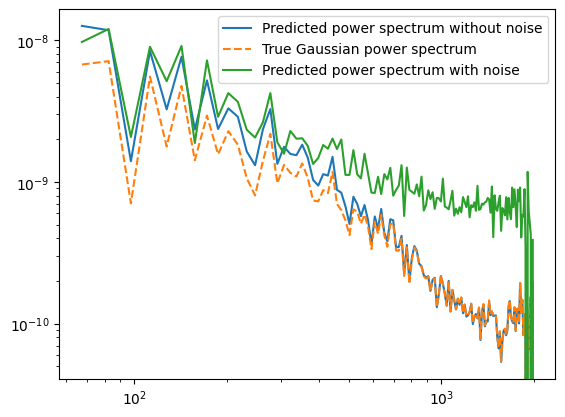

In [50]:
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(out_vae.squeeze(), angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

# map_g = projection_gaussian - projection_gaussian.mean()
kmap_lt_true = ConvergenceMap(
    projection_gaussian.squeeze(), angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)
kmap_lt_predicted = ConvergenceMap(sample_vae.squeeze(), angle=map_size * u.deg)
l3, Pl3 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)


plt.figure()
plt.loglog(l1, Pl1, label="Predicted power spectrum without noise")
plt.loglog(l2, Pl2, "--", label="True Gaussian power spectrum")
plt.loglog(l3, Pl3, label="Predicted power spectrum with noise")
plt.legend()

In [51]:
data_store = []
masterkey = jax.random.PRNGKey(0)
nb_of_projected_map = 100
for k in range(nb_of_projected_map):
    masterkey, key1, key2 = jax.random.split(masterkey, 3)
    lon = jax.random.randint(key1, (nb_of_projected_map,), -180, 180)
    lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
    proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
    m_data_proj = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
    data_store.append(m_data_proj)

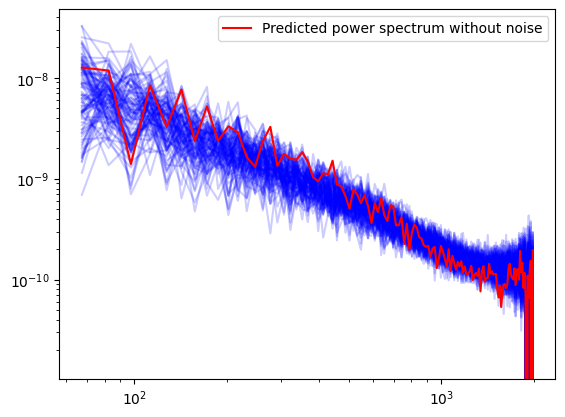

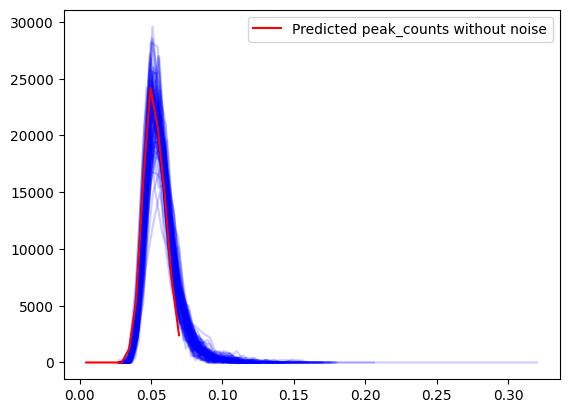

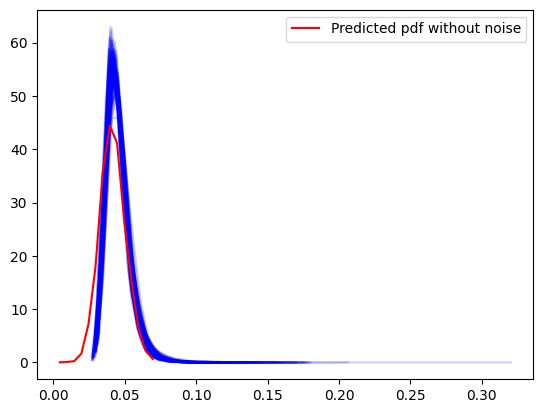

In [52]:
predicted_map = out_vae.squeeze()

noise = 'without noise'

# power spctrum

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    kmap_lt_true = ConvergenceMap(
        true_map, angle=map_size * u.deg
    )
    l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

    plt.loglog(l2, Pl2, alpha = 0.2, c = 'blue')

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}",c='red')
plt.legend()

# peak count 
plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = peak_counts(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}",c='red')
plt.legend()

# pdf

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = pdf(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = pdf(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}",c='red')
plt.legend()


In [53]:
data_store = []
masterkey = jax.random.PRNGKey(0)
nb_of_projected_map = 100
for k in range(nb_of_projected_map):
    masterkey, key1, key2, key3 = jax.random.split(masterkey, 4)
    lon = jax.random.randint(key1, (nb_of_projected_map,), -180, 180)
    lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
    proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
    m_data_proj = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
    m_data_proj_noisy = dist.Independent(
    dist.Normal(
        m_data_proj,
        sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
    ),
    2,
    ).sample(key3, (1,))
    data_store.append(m_data_proj_noisy.squeeze())

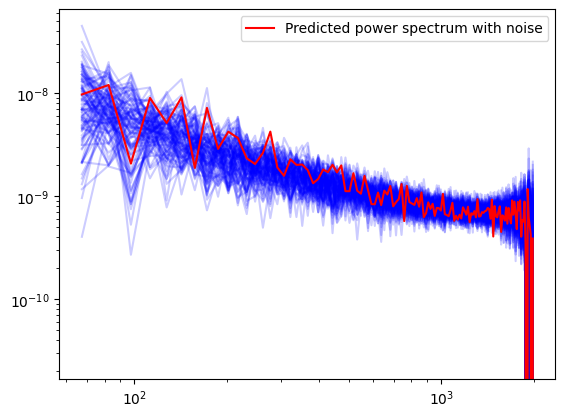

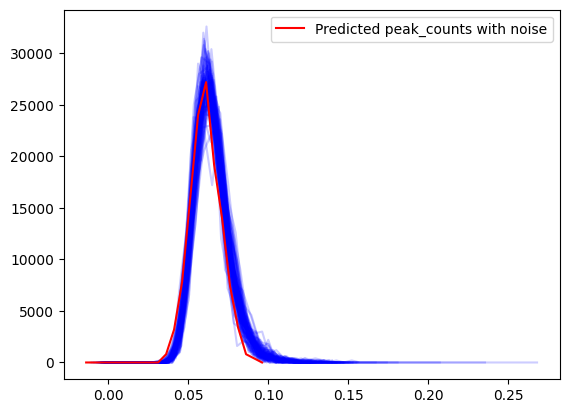

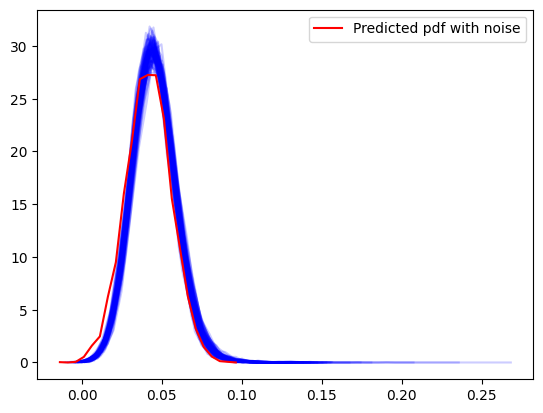

In [54]:
predicted_map = sample_vae.squeeze()

noise = 'with noise'

# power spctrum

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    kmap_lt_true = ConvergenceMap(
        true_map, angle=map_size * u.deg
    )
    l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

    plt.loglog(l2, Pl2, alpha = 0.2, c = 'blue')

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}",c='red')
plt.legend()

# peak count 
plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = peak_counts(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}",c='red')
plt.legend()

# pdf

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = pdf(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = pdf(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}",c='red')
plt.legend()


## From Guassian prior

In [64]:
import numpyro
from numpyro.handlers import condition, reparam, seed, trace
fiducial_model = numpyro.handlers.condition(
    learned_forward_model, 
    {
        "Om": cosmo_parameters[0][0], 
        "s8": cosmo_parameters[0][1], 
        "w0": cosmo_parameters[0][2], 
        "h": cosmo_parameters[0][3], 
        "ns": cosmo_parameters[0][4],
        "Ob": cosmo_parameters[0][5], 
    }
)

model_trace = numpyro.handlers.trace(seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()
gaussian_map_prior = model_trace['x']['fn'].mean

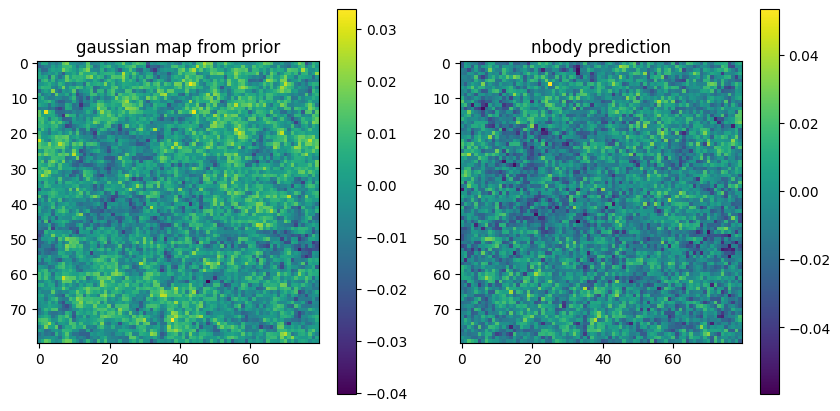

In [65]:
out_vae, _ = decoder_eval.apply(vae_params, state[1],gaussian_map_prior)
sample_vae = posterior_x(out_vae.squeeze()).sample(jax.random.PRNGKey(10))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(gaussian_map_prior)
plt.title("gaussian map from prior")
plt.colorbar()
plt.subplot(122)
plt.imshow(sample_vae.squeeze())
plt.title("nbody prediction")
plt.colorbar()

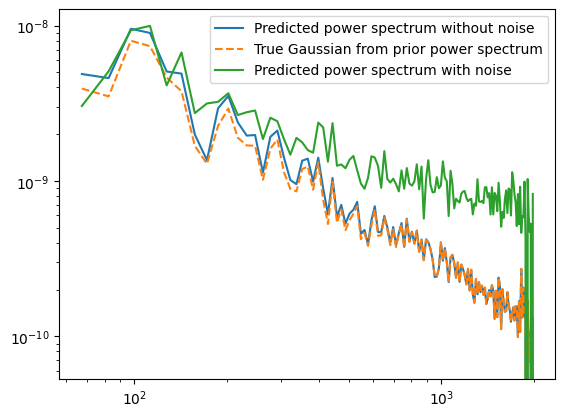

In [66]:
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(out_vae.squeeze(), angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

# map_g = projection_gaussian - projection_gaussian.mean()
kmap_lt_true = ConvergenceMap(
    gaussian_map_prior.squeeze(), angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)
kmap_lt_predicted = ConvergenceMap(sample_vae.squeeze(), angle=map_size * u.deg)
l3, Pl3 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)


plt.figure()
plt.loglog(l1, Pl1, label="Predicted power spectrum without noise")
plt.loglog(l2, Pl2, "--", label="True Gaussian from prior power spectrum")
plt.loglog(l3, Pl3, label="Predicted power spectrum with noise")
plt.legend()

In [67]:
data_store = []
masterkey = jax.random.PRNGKey(0)
nb_of_projected_map = 100
for k in range(nb_of_projected_map):
    masterkey, key1, key2, key3 = jax.random.split(masterkey, 4)
    lon = jax.random.randint(key1, (nb_of_projected_map,), -180, 180)
    lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
    proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
    m_data_proj = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
    # m_data_proj_noisy = dist.Independent(
    # dist.Normal(
    #     m_data_proj,
    #     sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
    # ),
    # 2,
    # ).sample(key3, (1,))
    data_store.append(m_data_proj.squeeze())

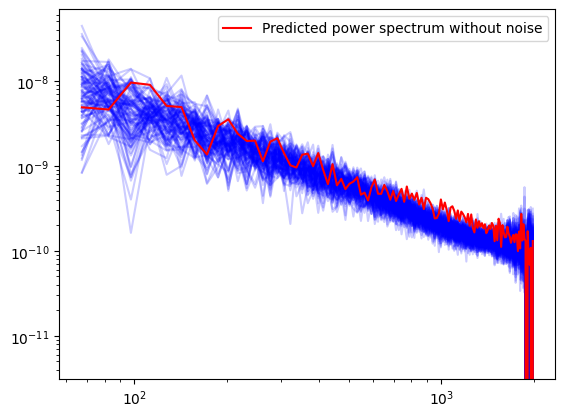

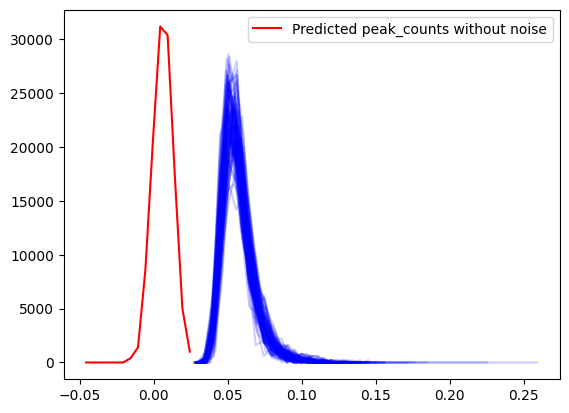

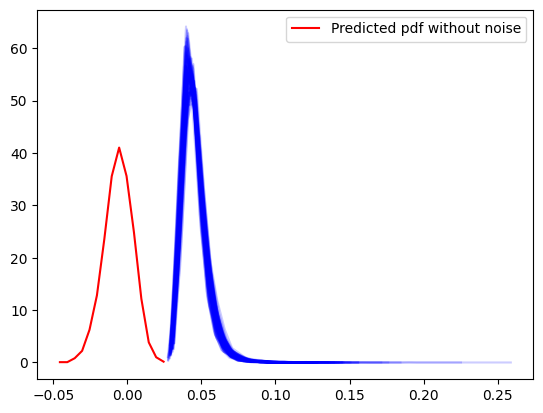

In [68]:
predicted_map = out_vae.squeeze()

noise = 'without noise'

# power spctrum

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    kmap_lt_true = ConvergenceMap(
        true_map, angle=map_size * u.deg
    )
    l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

    plt.loglog(l2, Pl2, alpha = 0.2, c = 'blue')

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}",c='red')
plt.legend()

# peak count 
plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = peak_counts(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}",c='red')
plt.legend()

# pdf

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = pdf(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = pdf(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}",c='red')
plt.legend()


In [69]:
data_store = []
masterkey = jax.random.PRNGKey(0)
nb_of_projected_map = 100
for k in range(nb_of_projected_map):
    masterkey, key1, key2, key3 = jax.random.split(masterkey, 4)
    lon = jax.random.randint(key1, (nb_of_projected_map,), -180, 180)
    lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
    proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
    m_data_proj = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
    m_data_proj_noisy = dist.Independent(
    dist.Normal(
        m_data_proj,
        sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
    ),
    2,
    ).sample(key3, (1,))
    data_store.append(m_data_proj_noisy.squeeze())

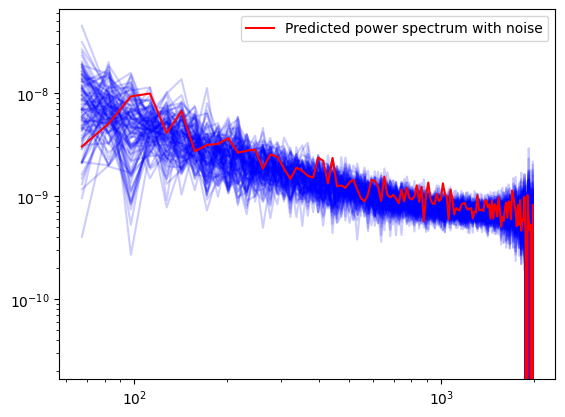

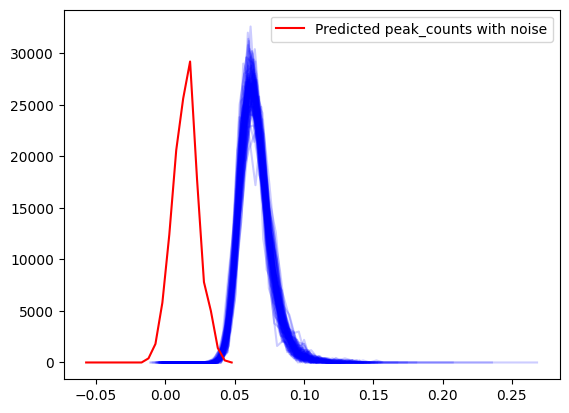

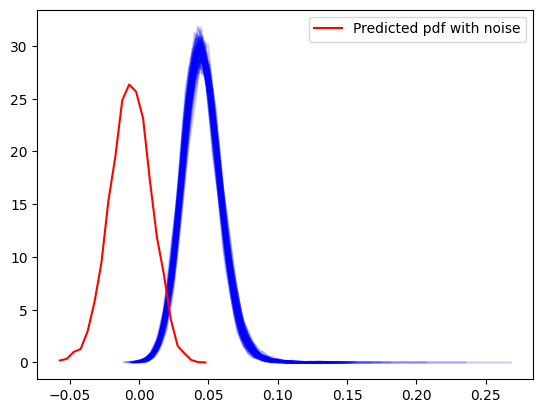

In [70]:
predicted_map = sample_vae.squeeze()

noise = 'with noise'

# power spctrum

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    kmap_lt_true = ConvergenceMap(
        true_map, angle=map_size * u.deg
    )
    l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

    plt.loglog(l2, Pl2, alpha = 0.2, c = 'blue')

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(predicted_map, angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)
plt.loglog(l1, Pl1, label=f"Predicted power spectrum {noise}",c='red')
plt.legend()

# peak count 
plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = peak_counts(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = peak_counts(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted peak_counts {noise}",c='red')
plt.legend()

# pdf

plt.figure()

for i in range(nb_of_projected_map):
    true_map = data_store[i]
    nu, peaks = pdf(true_map, map_size)
    plt.plot(nu, peaks, alpha = 0.2, c = 'blue')

nu_vae, peaks_vae = pdf(predicted_map, map_size)
plt.plot(nu_vae, peaks_vae, label=f"Predicted pdf {noise}",c='red')
plt.legend()


## Comparing guassian map to cosmogrid map

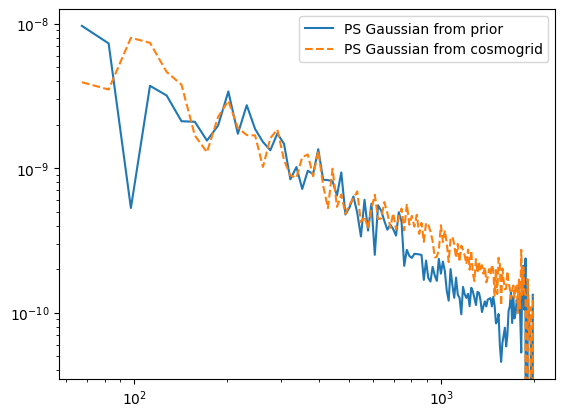

In [35]:
l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
kmap_lt_predicted = ConvergenceMap(projection_gaussian.squeeze(), angle=map_size * u.deg)
l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    gaussian_map_prior.squeeze(), angle=map_size * u.deg
)
l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)


plt.figure()
plt.loglog(l1, Pl1, label="PS Gaussian from prior")
plt.loglog(l2, Pl2, "--", label="PS Gaussian from cosmogrid")
plt.legend()

## Testing different cosmology prior Gaussian map


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.14214759 
 s8 0.67871916 
 w0 -0.48330784 
 h 0.76360375 
 ns 0.92165756 
 Ob 0.04757852


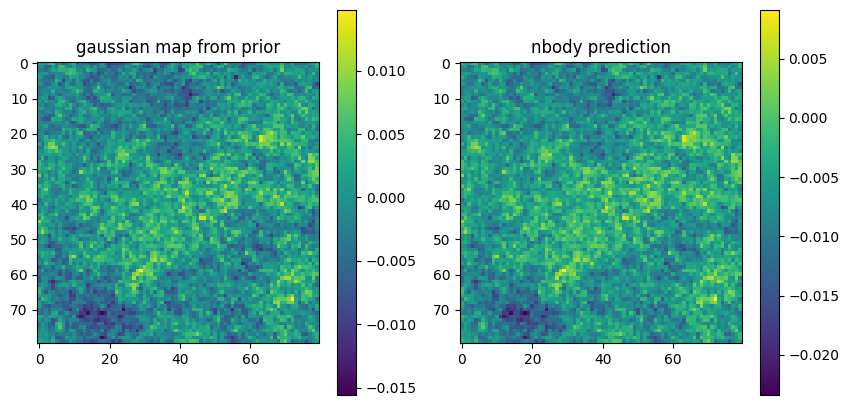

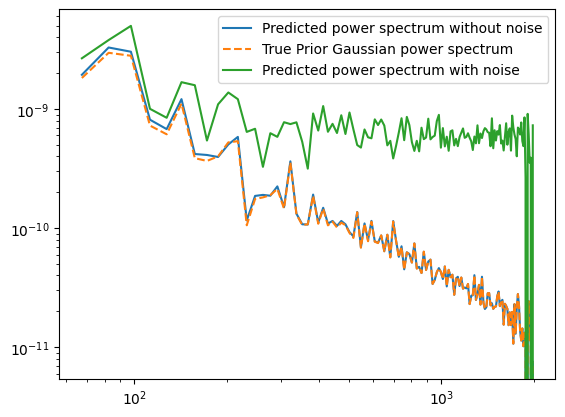


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.15027471 
 s8 0.53738046 
 w0 -0.5770552 
 h 0.7068245 
 ns 0.8960619 
 Ob 0.052324355


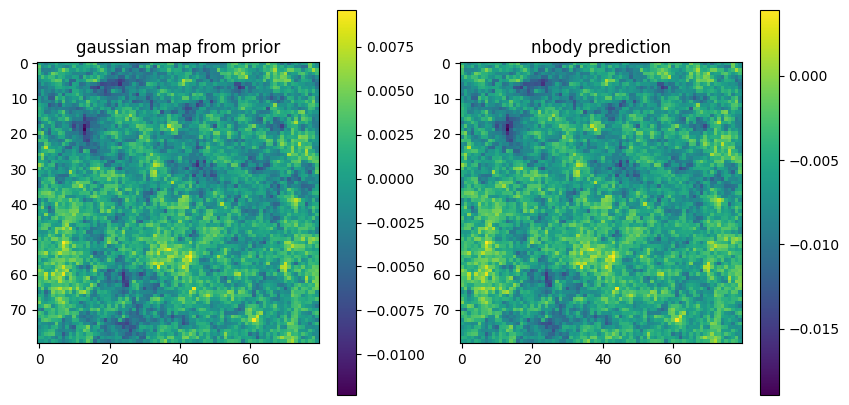

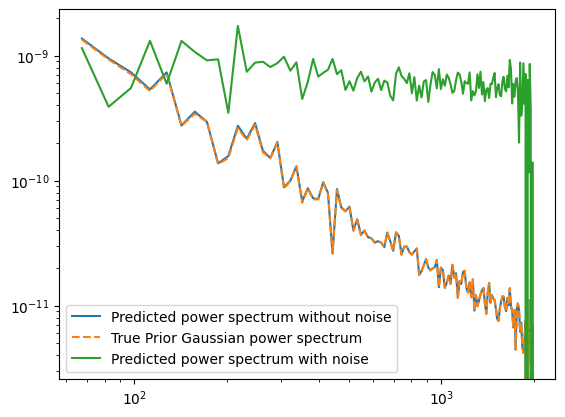


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.27345005 
 s8 1.018532 
 w0 -0.7238672 
 h 0.7377067 
 ns 0.9576471 
 Ob 0.038040858


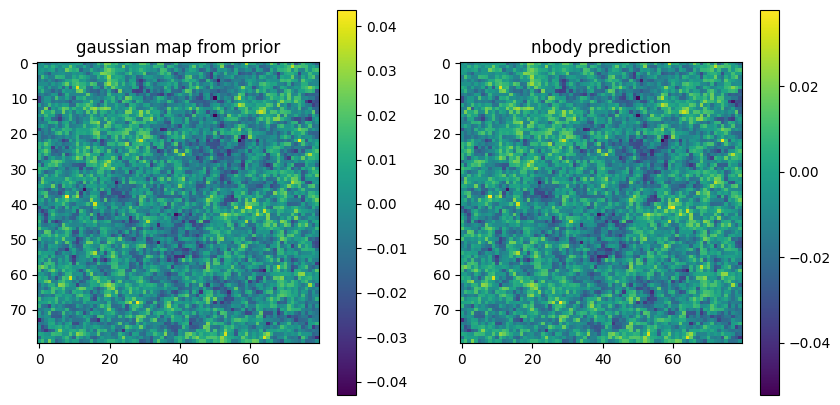

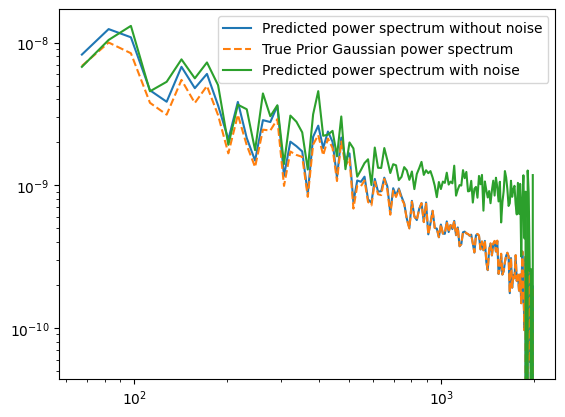


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.2906103 
 s8 1.243591 
 w0 -1.4132333 
 h 0.67542917 
 ns 0.96735424 
 Ob 0.040585857


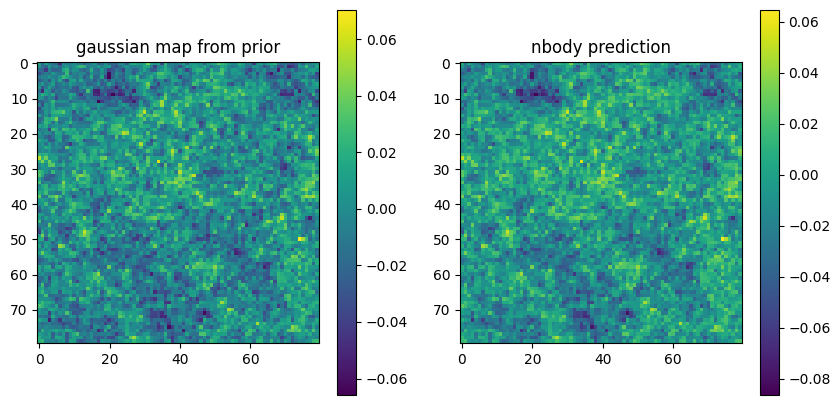

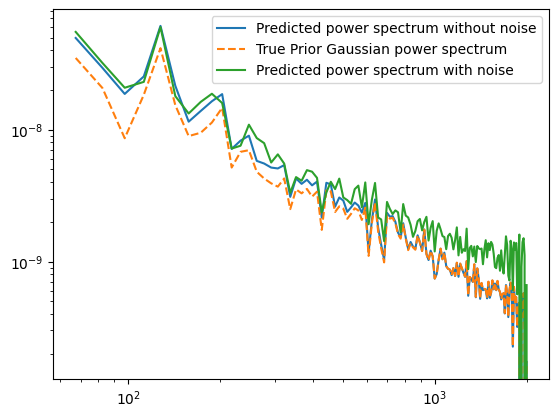


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.4137923 
 s8 0.6806835 
 w0 -0.81542075 
 h 0.8196388 
 ns 1.0261985 
 Ob 0.035878144


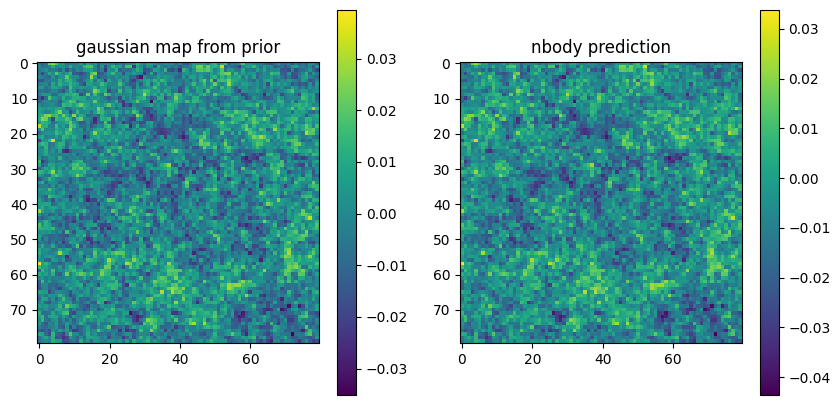

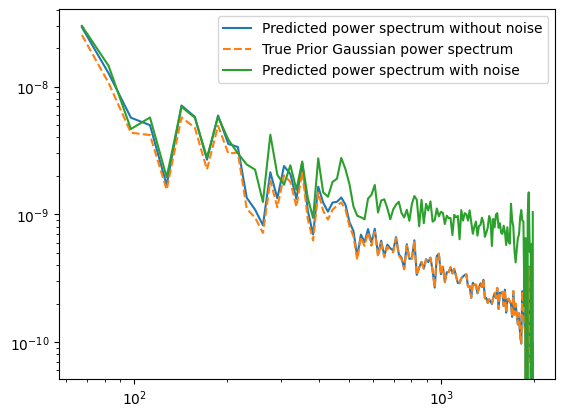


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.4425598 
 s8 1.182977 
 w0 -0.34807456 
 h 0.76394534 
 ns 0.97853255 
 Ob 0.039541554


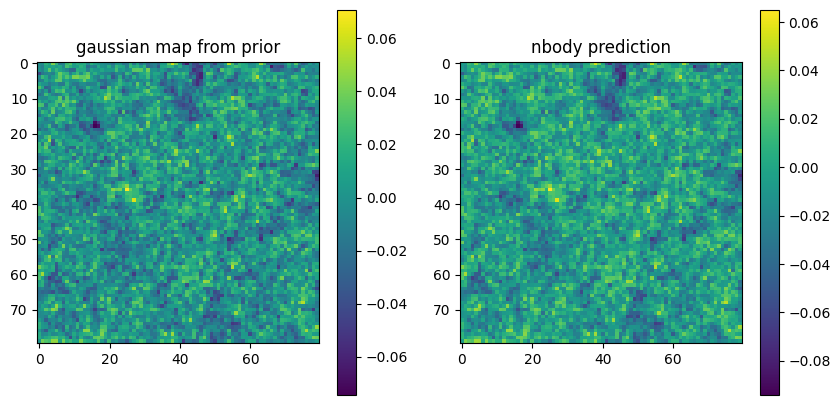

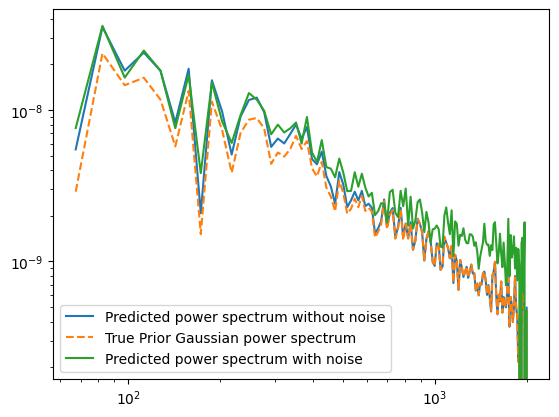


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.17020269 
 s8 1.1669602 
 w0 -0.56217694 
 h 0.6856367 
 ns 0.8744863 
 Ob 0.039271202


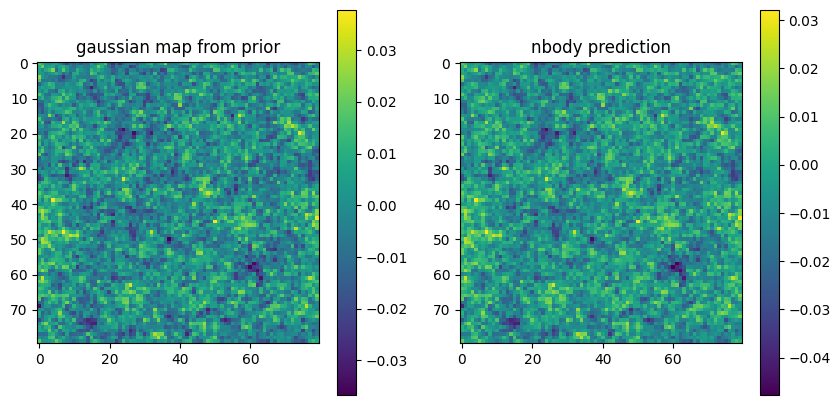

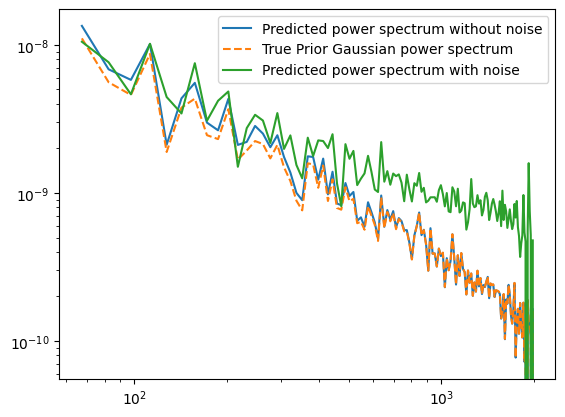


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.12873726 
 s8 1.3784348 
 w0 -1.8777739 
 h 0.6888712 
 ns 0.9521386 
 Ob 0.038338322


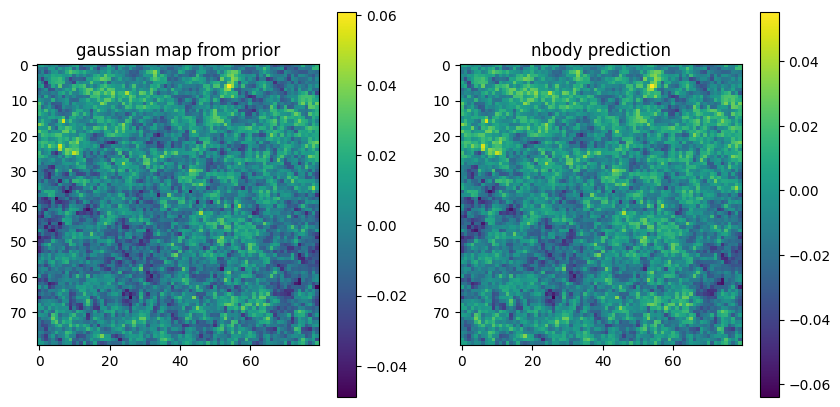

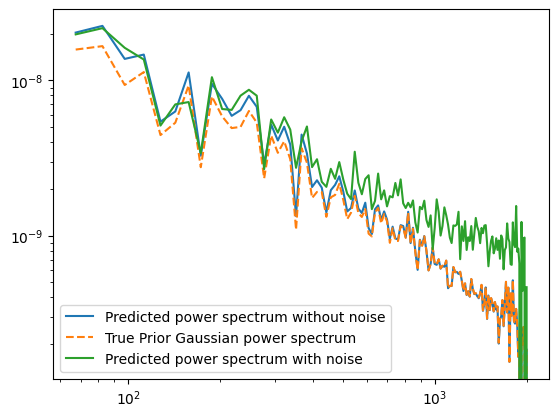


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.28336272 
 s8 0.6927185 
 w0 -1.0522695 
 h 0.6474901 
 ns 0.93463695 
 Ob 0.04166552


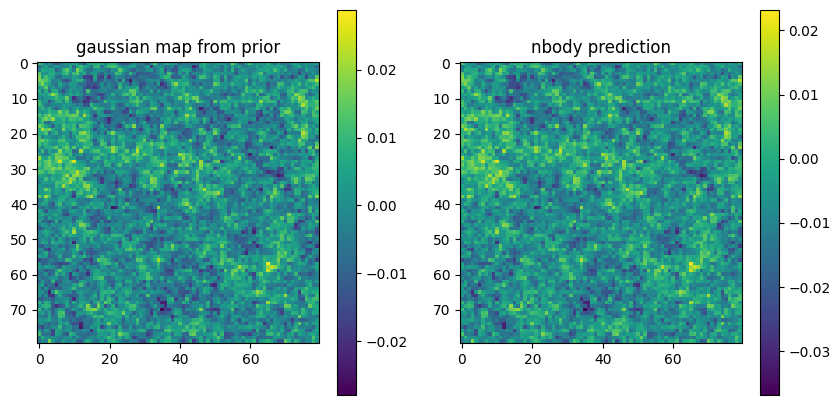

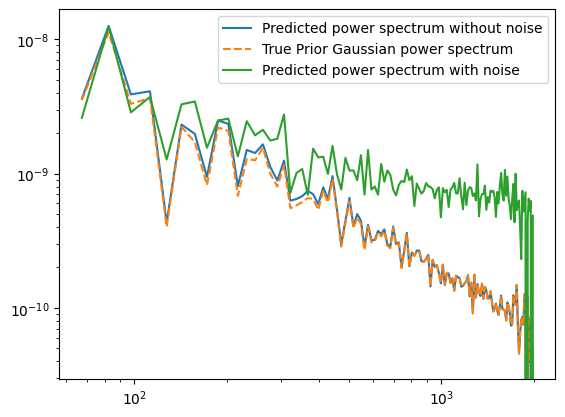


 Om 0.26 
 s8 0.84 
 w0 -1.0 
 h 0.6736 
 ns 0.9649 
 Ob 0.0493

 Om 0.26229706 
 s8 0.5486859 
 w0 -1.8551928 
 h 0.7070616 
 ns 0.9608976 
 Ob 0.05617988


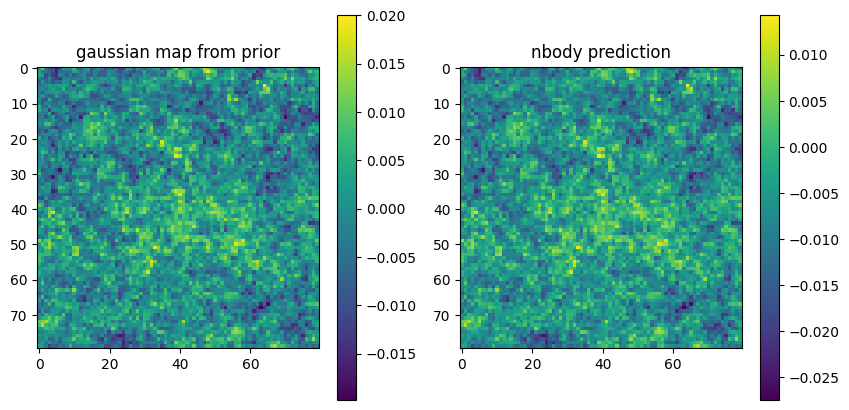

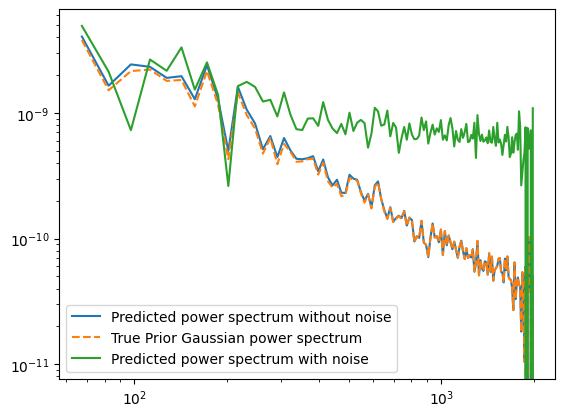

In [30]:
import numpyro
from numpyro.handlers import condition, reparam, seed, trace

for i in range(10):
    model_trace = numpyro.handlers.trace(seed(learned_forward_model, jax.random.PRNGKey(i))).get_trace()
    gaussian_map_prior = model_trace['x']['fn'].mean
    print(
    "\n Om", cosmo_parameters[0][0], 
    "\n s8", cosmo_parameters[0][1], 
    "\n w0", cosmo_parameters[0][2], 
    "\n h", cosmo_parameters[0][3], 
    "\n ns", cosmo_parameters[0][4],
    "\n Ob", cosmo_parameters[0][5]
    )
    
    print(
    "\n Om", model_trace['Om']['value'], 
    "\n s8",  model_trace['s8']['value'], 
    "\n w0",  model_trace['w0']['value'], 
    "\n h",  model_trace['h']['value'], 
    "\n ns",  model_trace['ns']['value'], 
    "\n Ob",  model_trace['Ob']['value'], 
    )
    
    
    out_vae, _ = decoder_eval.apply(vae_params, state[1],gaussian_map_prior)
    sample_vae = posterior_x(out_vae.squeeze()).sample(jax.random.PRNGKey(i+10))
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(gaussian_map_prior)
    plt.title("gaussian map from prior")
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(out_vae.squeeze())
    plt.title("nbody prediction")
    plt.colorbar()
    plt.show()
    
    l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
    kmap_lt_predicted = ConvergenceMap(out_vae.squeeze(), angle=map_size * u.deg)
    l1, Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)
    
    # map_g = projection_gaussian - projection_gaussian.mean()
    kmap_lt_true = ConvergenceMap(
        gaussian_map_prior.squeeze(), angle=map_size * u.deg
    )
    l2, Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)
    kmap_lt_predicted = ConvergenceMap(sample_vae.squeeze(), angle=map_size * u.deg)
    l3, Pl3 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)
    
    
    plt.figure()
    plt.loglog(l1, Pl1, label="Predicted power spectrum without noise")
    plt.loglog(l2, Pl2, "--", label="True Prior Gaussian power spectrum")
    plt.loglog(l3, Pl3, label="Predicted power spectrum with noise")
    plt.legend()
    plt.show()